📊 Starting Experiment 1: Data Diagnostics...
   Constructing DataFrame...
   Calculating Correlations...


/tmp/ipython-input-975/2006850951.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm_r')


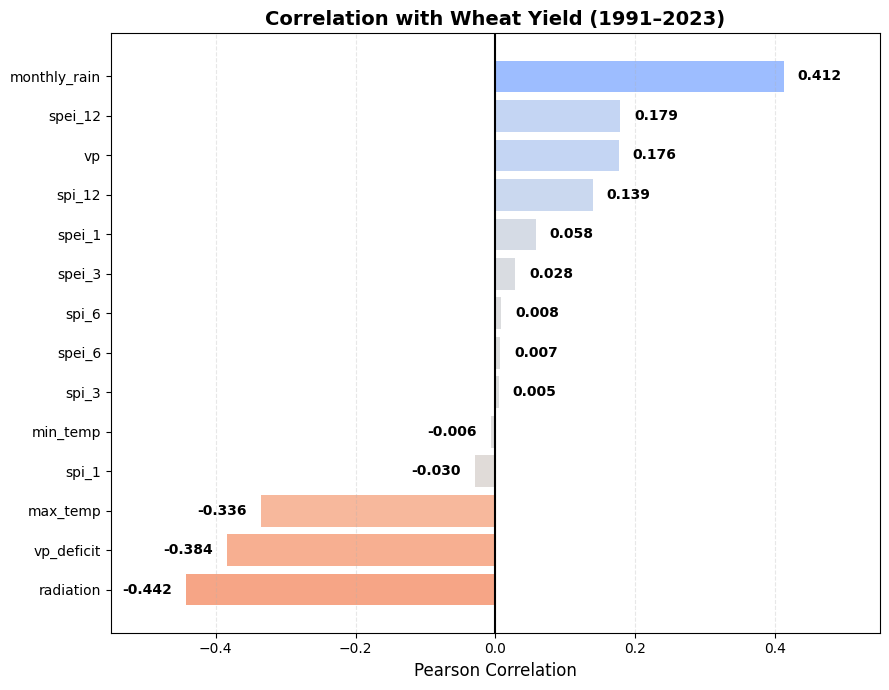

In [19]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# =========================================================
# CONFIGURATION
# =========================================================
DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_modified_sequence_with_yield"
YEARS = range(1991, 2024) # All available data

# Define the variables to check
# We will split them into "Raw Climate" and "Drought Indices" for cleaner plots
VARS_RAW = ['monthly_rain', 'max_temp', 'min_temp', 'radiation', 'vp', 'vp_deficit']
VARS_INDICES = ['spi_1', 'spi_3', 'spi_6', 'spi_12', 'spei_1', 'spei_3', 'spei_6', 'spei_12']

def run_experiment_1():
    print("📊 Starting Experiment 1: Data Diagnostics...")

    # Storage for flattened data
    data_storage = {var: [] for var in VARS_RAW + VARS_INDICES}
    data_storage['yield'] = []

    # 1. Load Data (Sub-sample if RAM is tight, but full data is better)
    # We will load every 10th pixel to speed up calculation without losing statistical significance
    stride = 10

    for year in YEARS:
        try:
            fpath = os.path.join(DATA_DIR, f"final_dataset_{year}.nc")
            ds = xr.open_dataset(fpath)

            # Get Yield Mask (Valid Farms)
            y_map = ds['yield'].values
            mask = ~np.isnan(y_map)

            # Store Yield
            data_storage['yield'].append(y_map[mask][::stride])

            # Store Climate Vars (Avg over season? Or correlate per month?)
            # CHALLENGE: You have 6 months (May-Oct).
            # A simple correlation matrix usually needs 1 value per year.
            # OPTION A: Correlate "September Rain" vs Yield.
            # OPTION B: Correlate "Seasonal Average Rain" vs Yield.

            # Let's do OPTION A: We will create columns like "Rain_May", "Rain_Jun", etc.
            # WAIT: That would be 14 vars * 6 months = 84 rows in heatmap. Too big.

            # BETTER APPROACH:
            # We will calculate correlation for "Critical Window" (e.g. Sep/Oct) vs "Early Season" (May/Jun).
            # But for simplicity, let's first check correlation of the VARIABLE (averaged over growing season) vs Yield.

            for var in VARS_RAW + VARS_INDICES:
                # Shape: (6, H, W) -> Mean over time -> (H, W)
                # We interpret this as "Seasonal Average Condition"
                val_map = ds[var].mean(dim='time').values

                # Check for NaNs in inputs (Ocean)
                val_map = np.nan_to_num(val_map, nan=0.0)

                data_storage[var].append(val_map[mask][::stride])

        except FileNotFoundError:
            print(f"Skipping {year}")

    # 2. Convert to DataFrame
    print("   Constructing DataFrame...")
    # Concatenate all years
    df_dict = {}
    for key in data_storage:
        if len(data_storage[key]) > 0:
            df_dict[key] = np.concatenate(data_storage[key])

    df = pd.DataFrame(df_dict)

    # 3. Calculate Correlation Matrix
    print("   Calculating Correlations...")
    # We only care about correlation with 'yield'
    corr_matrix = df.corr()[['yield']].sort_values(by='yield', ascending=False)

    # Drop the yield row itself
    corr_matrix = corr_matrix.drop('yield')

    # 4. Plotting
    # Compute correlation
    corr_series = df.corr()['yield'].drop('yield').sort_values()

    # Normalize colors between -1 and 1
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('coolwarm_r')
    colors = cmap(norm(corr_series.values))

    plt.figure(figsize=(9, 7))

    bars = plt.barh(corr_series.index, corr_series.values, color=colors)

    # Zero reference line
    plt.axvline(0, color='black', linewidth=1.5)

    # Add correlation values on bars
    for i, v in enumerate(corr_series.values):
        plt.text(
            v + 0.02 if v > 0 else v - 0.02,   # shift slightly
            i,
            f"{v:.3f}",
            va='center',
            ha='left' if v > 0 else 'right',
            fontsize=10,
            fontweight='bold'
        )

    plt.title("Correlation with Wheat Yield (1991–2023)", fontsize=14, fontweight='bold')
    plt.xlabel("Pearson Correlation", fontsize=12)
    plt.xlim(-0.55, 0.55)
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Run it
df_diagnostic = run_experiment_1()

Train loader and Test loader

In [20]:
import os
import torch
import xarray as xr
import numpy as np
from torch.utils.data import Dataset, DataLoader

class WheatYieldDataset(Dataset):
    def __init__(self, data_dir, years, mode='train', scaler=None):
        """
        Args:
            data_dir (str): Path to 'final_sequences_with_yield'
            years (list): List of years for this split (e.g. 1991-2010)
            mode (str): 'train', 'val', or 'test'
            scaler (dict): Mean/Std dict from training set (needed for val/test)
        """
        self.files = [os.path.join(data_dir, f"final_dataset_{y}.nc") for y in years]
        self.mode = mode

        # 1. Define Variables (The Order Matters!)
        # Ensure these match your NetCDF variable names exactly
        self.feature_vars = [
            'monthly_rain', 'max_temp', 'min_temp', 'radiation',
            'vp', 'vp_deficit',
            'spi_1', 'spi_3', 'spi_6', 'spi_12',
            'spei_1', 'spei_3', 'spei_6', 'spei_12'
        ]

        # 2. Load Data into RAM
        # Since we have ~33 files (approx 500MB total), we can load it all into RAM
        # for extremely fast training speed.
        self.X_data = []
        self.y_data = []

        print(f"[{mode.upper()}] Loading {len(years)} years...")

        for fpath in self.files:
            try:
                ds = xr.open_dataset(fpath)

                # A. Create Yield Mask (Where yield is NOT NaN)
                y_np = ds['yield'].values # Shape: (lat, lon)
                mask = ~np.isnan(y_np)    # Boolean mask of valid farms

                # B. Extract Inputs (Features)
                year_features = []
                for var in self.feature_vars:
                    # Shape: (Time=6, Lat, Lon)
                    data = ds[var].values

                    # Select only valid pixels -> Result: (Time=6, N_valid_pixels)
                    valid_pixels = data[:, mask]
                    year_features.append(valid_pixels)

                # Stack features
                # Current shape: List of (6, N).
                # Stack to (Channels, 6, N) then Transpose to (N, 6, Channels)
                X_year = np.stack(year_features, axis=0)
                X_year = np.transpose(X_year, (2, 1, 0))

                # C. Extract Targets
                y_year = y_np[mask] # Shape: (N,)

                # D. Handle NaNs in INPUTS (e.g., if SPI is missing but Yield exists)
                # We replace input NaNs with 0.0 (which is the mean in Z-score world)
                X_year = np.nan_to_num(X_year, nan=0.0)

                self.X_data.append(X_year)
                self.y_data.append(y_year)

            except FileNotFoundError:
                print(f"⚠️ Missing file: {fpath}")

        # Concatenate all years into one giant Tensor
        if len(self.X_data) > 0:
            self.X_data = np.concatenate(self.X_data, axis=0) # (Total_Samples, 6, 14)
            self.y_data = np.concatenate(self.y_data, axis=0) # (Total_Samples,)
            print(f"[{mode.upper()}] Loaded {self.X_data.shape[0]} samples.")
        else:
            print(f"[{mode.upper()}] ❌ No data loaded!")
            return

        # 3. Normalization (Standardization)
        # We MUST calculate mean/std only on TRAIN data, then apply to Val/Test
        if mode == 'train':
            print("   Computing statistics...")
            # Calculate mean/std across Samples (0) and Time (1)
            mean = np.mean(self.X_data, axis=(0, 1))
            std = np.std(self.X_data, axis=(0, 1))
            self.scaler = {'mean': mean, 'std': std}
        else:
            self.scaler = scaler

        # Apply (X - Mean) / Std
        # Add 1e-6 to std to avoid division by zero
        self.X_data = (self.X_data - self.scaler['mean']) / (self.scaler['std'] + 1e-6)

        # Convert to PyTorch Tensors
        self.X_data = torch.tensor(self.X_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32).unsqueeze(1) # (N, 1)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

# =========================================================
# HELPER: Get All Loaders
# =========================================================
def get_dataloaders(data_dir, batch_size=1024):
    # Standard Time-Series Split
    train_years = range(1991, 2011) # 20 Years
    val_years   = range(2011, 2018) # 7 Years
    test_years  = range(2018, 2024) # 6 Years (The "Future")

    # 1. Train
    train_ds = WheatYieldDataset(data_dir, train_years, mode='train')

    # 2. Val (Pass the train scaler!)
    val_ds = WheatYieldDataset(data_dir, val_years, mode='val', scaler=train_ds.scaler)

    # 3. Test (Pass the train scaler!)
    test_ds = WheatYieldDataset(data_dir, test_years, mode='test', scaler=train_ds.scaler)

    # Create PyTorch DataLoaders
    # num_workers=2 speeds up data fetching
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [21]:
# Update this path to your "final_sequences_with_yield" folder
DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_modified_sequence_with_yield"

# Initialize Loaders
train_loader, val_loader, test_loader = get_dataloaders(DATA_DIR, batch_size=1024)

# Grab one batch to check shapes
X_batch, y_batch = next(iter(train_loader))

print(f"\n✅ Data Loading Successful!")
print(f"Input Batch Shape:  {X_batch.shape}")
print(f"Target Batch Shape: {y_batch.shape}")

# EXPECTED OUTPUT:
# Input:  torch.Size([1024, 6, 14])  -> (Batch, Time, Variables)
# Target: torch.Size([1024, 1])      -> (Batch, Yield)

[TRAIN] Loading 20 years...
[TRAIN] Loaded 152537 samples.
   Computing statistics...
[VAL] Loading 7 years...
[VAL] Loaded 53436 samples.
[TEST] Loading 6 years...
[TEST] Loaded 45680 samples.

✅ Data Loading Successful!
Input Batch Shape:  torch.Size([1024, 6, 14])
Target Batch Shape: torch.Size([1024, 1])


🌲 Starting Experiment 2: Random Forest Baseline...
   Flattening data...
   Train Shape: (152537, 84)
   Test Shape:  (45680, 84)
   Training (this may take 5-10 mins)...
   Predicting...

📊 RANDOM FOREST RESULTS:
-------------------------
RMSE:  0.6469 t/ha
MAE:   0.5213 t/ha
NRMSE: 0.3004
R²:    0.2642


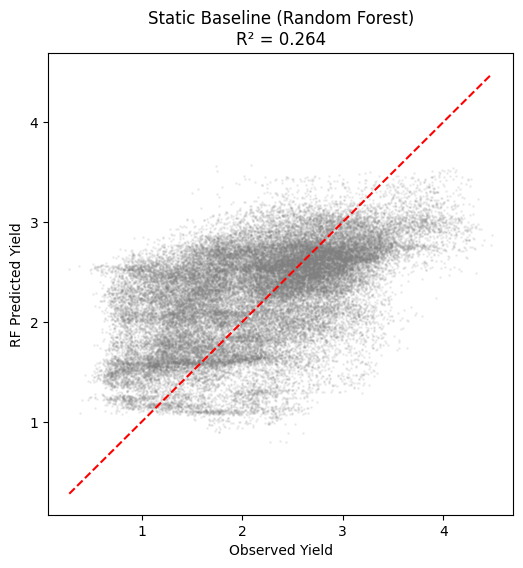

In [22]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# Re-use your existing 'get_dataloaders' from the previous setup
# to ensure we use the EXACT same Train/Test split.

def run_experiment_2(train_loader, test_loader):
    print("🌲 Starting Experiment 2: Random Forest Baseline...")

    # 1. Flatten the Time-Series Data
    # LSTM Input: (Batch, Time=6, Feat=14)
    # RF Input:   (Batch, Time*Feat=84)

    def flatten_loader(loader):
        X_list, y_list = [], []
        for X, y in loader:
            # Flatten (Batch, 6, 14) -> (Batch, 84)
            batch_flat = X.reshape(X.shape[0], -1).numpy()
            X_list.append(batch_flat)
            y_list.append(y.numpy().ravel())

        return np.concatenate(X_list), np.concatenate(y_list)

    print("   Flattening data...")
    X_train, y_train = flatten_loader(train_loader)
    X_test, y_test = flatten_loader(test_loader)

    print(f"   Train Shape: {X_train.shape}")
    print(f"   Test Shape:  {X_test.shape}")

    # 2. Train Random Forest
    # n_jobs=-1 uses all CPU cores
    rf = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)

    print("   Training (this may take 5-10 mins)...")
    rf.fit(X_train, y_train)

    # 3. Evaluate
    print("   Predicting...")
    y_pred = rf.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # NRMSE (normalized by mean observed yield)
    nrmse = rmse / np.mean(y_test)

    print(f"\n📊 RANDOM FOREST RESULTS:")
    print(f"-------------------------")
    print(f"RMSE:  {rmse:.4f} t/ha")
    print(f"MAE:   {mae:.4f} t/ha")
    print(f"NRMSE: {nrmse:.4f}")
    print(f"R²:    {r2:.4f}")

    # 4. Save Model & Plot
    joblib.dump(rf, "rf_baseline.pkl")

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.1, s=1, color='gray')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Observed Yield")
    plt.ylabel("RF Predicted Yield")
    plt.title(f"Static Baseline (Random Forest)\nR² = {r2:.3f}")
    plt.show()

# --- HOW TO RUN ---
# Assuming you have 'train_loader' and 'test_loader' from your main data script:
run_experiment_2(train_loader, test_loader)

⏳ Starting Experiment 3: Standard LSTM...
   Using device: cpu
   Training for 30 epochs...
   Epoch 5/30 | Train MSE: 0.0945 | Val MSE: 0.2279
   Epoch 10/30 | Train MSE: 0.0743 | Val MSE: 0.2058
   Epoch 15/30 | Train MSE: 0.0610 | Val MSE: 0.1935
   Epoch 20/30 | Train MSE: 0.0531 | Val MSE: 0.1833
   Epoch 25/30 | Train MSE: 0.0475 | Val MSE: 0.2028
   Epoch 30/30 | Train MSE: 0.0438 | Val MSE: 0.2053
   Training Time: 29.4 mins
   Evaluating on Test Set (2018-2023)...

📊 STANDARD LSTM RESULTS:
-------------------------
RMSE:   0.5156 t/ha
MAE:    0.4182 t/ha
NRMSE:  0.2395 (23.95%)
Bias:   0.1649 t/ha
R²:     0.5326


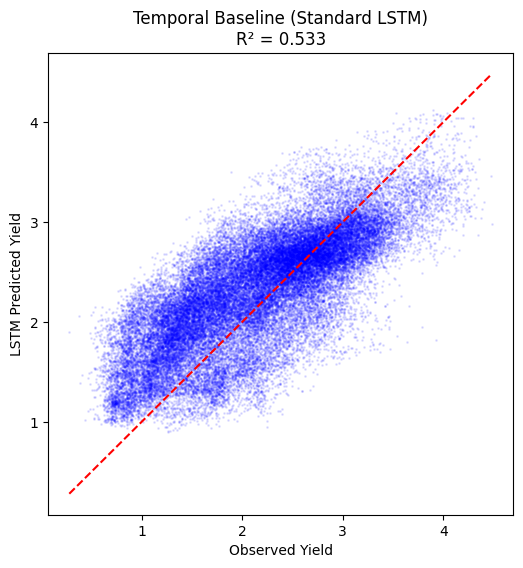

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import time

# =========================================================
# MODEL DEFINITION: STANDARD LSTM
# =========================================================
class StandardLSTM(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128, n_layers=2, dropout=0.2):
        super(StandardLSTM, self).__init__()

        # LSTM Layer: Reads the sequence
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )

        # Head: Predicts from the FINAL hidden state
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: (Batch, Time=6, Vars=14)
        lstm_out, _ = self.lstm(x)

        # We take only the LAST time step (October's state)
        # This implies the model must "remember" May-Sept in this final vector
        last_hidden = lstm_out[:, -1, :]

        return self.fc(last_hidden)

# =========================================================
# TRAINING FUNCTION
# =========================================================
def run_experiment_3(train_loader, val_loader, test_loader, device=None):
    print("⏳ Starting Experiment 3: Standard LSTM...")

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"   Using device: {device}")

    model = StandardLSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training Loop
    epochs = 30
    best_loss = float('inf')
    train_losses, val_losses = [], []

    print(f"   Training for {epochs} epochs...")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_batch_losses.append(loss.item())

        val_loss = np.mean(val_batch_losses)
        val_losses.append(val_loss)

        # Save Best
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_lstm_standard.pth")

        if (epoch+1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{epochs} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

    print(f"   Training Time: {(time.time()-start_time)/60:.1f} mins")

    # =========================================================
    # EVALUATION
    # =========================================================
    print("   Evaluating on Test Set (2018-2023)...")
    model.load_state_dict(torch.load("best_lstm_standard.pth"))
    model.eval()

    all_preds, all_true = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            all_preds.append(preds.cpu().numpy())
            all_true.append(y.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Normalized RMSE (by mean observed yield)
    mean_yield = np.mean(y_true)
    nrmse = rmse / mean_yield

    # Bias (systematic over/under prediction)
    bias = np.mean(y_pred - y_true)

    print(f"\n📊 STANDARD LSTM RESULTS:")
    print(f"-------------------------")
    print(f"RMSE:   {rmse:.4f} t/ha")
    print(f"MAE:    {mae:.4f} t/ha")
    print(f"NRMSE:  {nrmse:.4f} ({nrmse*100:.2f}%)")
    print(f"Bias:   {bias:.4f} t/ha")
    print(f"R²:     {r2:.4f}")

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.1, s=1, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"Temporal Baseline (Standard LSTM)\nR² = {r2:.3f}")
    plt.xlabel("Observed Yield")
    plt.ylabel("LSTM Predicted Yield")
    plt.show()

# Run it
run_experiment_3(train_loader, val_loader, test_loader)


⏳ Starting Experiment 3: Standard LSTM...
Using device: cpu
Epoch 5/30 | Train MSE: 0.0959 | Val MSE: 0.2471
Epoch 10/30 | Train MSE: 0.0743 | Val MSE: 0.2034
Epoch 15/30 | Train MSE: 0.0610 | Val MSE: 0.1974
Epoch 20/30 | Train MSE: 0.0527 | Val MSE: 0.1966
Epoch 25/30 | Train MSE: 0.0473 | Val MSE: 0.1934
Epoch 30/30 | Train MSE: 0.0435 | Val MSE: 0.1986
Training Time: 29.3 mins

Evaluating on Test Set...

📊 STANDARD LSTM RESULTS
-----------------------------
RMSE:   0.5220 t/ha
MAE:    0.4198 t/ha
NRMSE:  0.2425 (24.25%)
Bias:   0.1943 t/ha
R²:     0.5208


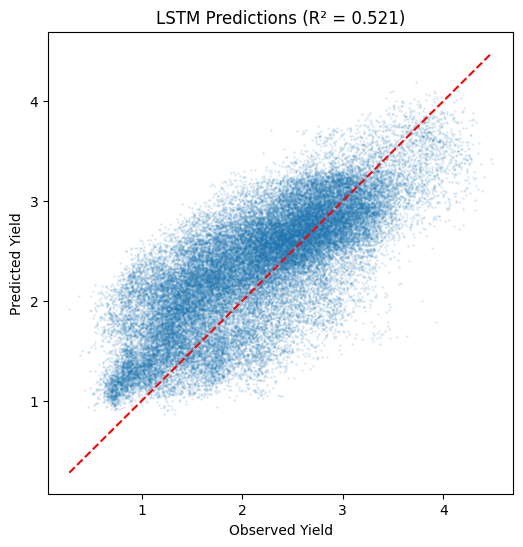

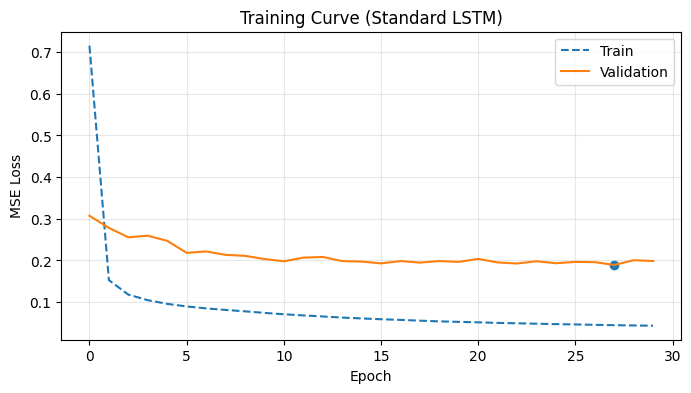

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

# =========================================================
# MODEL DEFINITION
# =========================================================
class StandardLSTM(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128, n_layers=2, dropout=0.2):
        super(StandardLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

# =========================================================
# TRAIN + EVALUATE
# =========================================================
def run_experiment_3(train_loader, val_loader, test_loader, device=None):

    print("⏳ Starting Experiment 3: Standard LSTM...")

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    model = StandardLSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epochs = 30
    best_loss = float('inf')
    train_losses, val_losses = [], []

    start_time = time.time()

    # ===============================
    # TRAINING LOOP
    # ===============================
    for epoch in range(epochs):

        model.train()
        batch_losses = []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        # ----- Validation -----
        model.eval()
        val_batch_losses = []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_batch_losses.append(loss.item())

        val_loss = np.mean(val_batch_losses)
        val_losses.append(val_loss)

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_lstm_standard.pth")

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train MSE: {train_loss:.4f} | "
                  f"Val MSE: {val_loss:.4f}")

    print(f"Training Time: {(time.time()-start_time)/60:.1f} mins")

    # ===============================
    # TEST EVALUATION
    # ===============================
    print("\nEvaluating on Test Set...")
    model.load_state_dict(torch.load("best_lstm_standard.pth"))
    model.eval()

    all_preds, all_true = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)

            all_preds.append(preds.cpu().numpy())
            all_true.append(y.cpu().numpy())

    y_pred = np.concatenate(all_preds).flatten()
    y_true = np.concatenate(all_true).flatten()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    nrmse = rmse / np.mean(y_true)
    bias = np.mean(y_pred - y_true)

    print("\n📊 STANDARD LSTM RESULTS")
    print("-----------------------------")
    print(f"RMSE:   {rmse:.4f} t/ha")
    print(f"MAE:    {mae:.4f} t/ha")
    print(f"NRMSE:  {nrmse:.4f} ({nrmse*100:.2f}%)")
    print(f"Bias:   {bias:.4f} t/ha")
    print(f"R²:     {r2:.4f}")

    # ===============================
    # PLOT 1: Predictions
    # ===============================
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.1, s=1)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--')
    plt.xlabel("Observed Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"LSTM Predictions (R² = {r2:.3f})")
    plt.show()

    # ===============================
    # PLOT 2: Training Curve
    # ===============================
    best_epoch = np.argmin(val_losses)

    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label="Train", linestyle='--')
    plt.plot(val_losses, label="Validation")
    plt.scatter(best_epoch, val_losses[best_epoch])
    plt.title("Training Curve (Standard LSTM)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Run
run_experiment_3(train_loader, val_loader, test_loader)

🚀 Starting Experiment 4: Proposed Res-Attn-LSTM
Using device: cpu
Epoch 5/40 | Train MSE: 0.1171 | Val MSE: 0.1879
Epoch 10/40 | Train MSE: 0.0936 | Val MSE: 0.2003
Epoch 15/40 | Train MSE: 0.0796 | Val MSE: 0.1918
Epoch 20/40 | Train MSE: 0.0690 | Val MSE: 0.2209
Epoch 25/40 | Train MSE: 0.0595 | Val MSE: 0.2140
Epoch 30/40 | Train MSE: 0.0513 | Val MSE: 0.2219
Epoch 35/40 | Train MSE: 0.0445 | Val MSE: 0.2264
Epoch 40/40 | Train MSE: 0.0393 | Val MSE: 0.2235
Training Time: 43.3 mins

Evaluating on Test Set...

🏆 PROPOSED MODEL RESULTS
--------------------------------
RMSE:   0.4907 t/ha
MAE:    0.4004 t/ha
NRMSE:  0.2279 (22.79%)
Bias:   0.2460 t/ha
R²:     0.5766


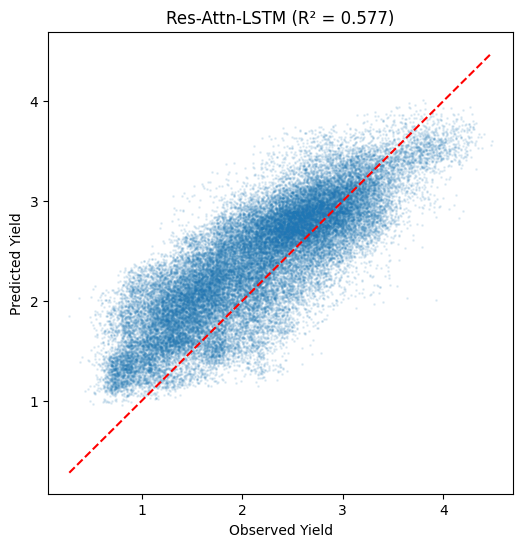

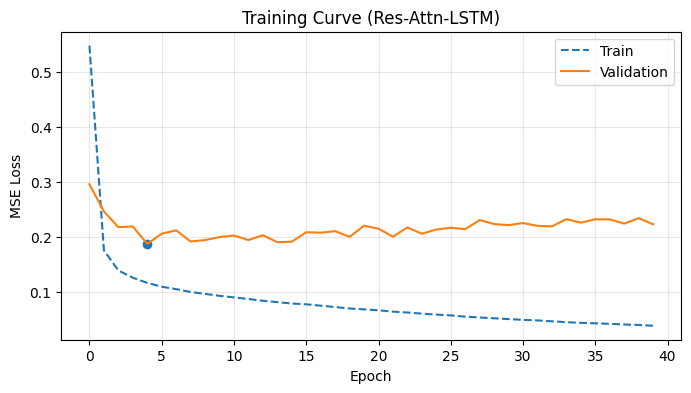

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# =========================================================
# 1️⃣ Residual LSTM Block
# =========================================================
class ResidualLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.project = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else None

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        residual = self.project(x) if self.project else x
        return self.layer_norm(out + residual)

# =========================================================
# 2️⃣ Deep Res-Attention Model
# =========================================================
class DeepYieldResNet(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128, n_layers=2, dropout=0.2):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(ResidualLSTM(input_dim, hidden_dim, dropout))
        for _ in range(n_layers - 1):
            self.layers.append(ResidualLSTM(hidden_dim, hidden_dim, dropout))

        self.att_fc = nn.Linear(hidden_dim, 1, bias=False)

        self.fc_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        curr_out = x
        for layer in self.layers:
            curr_out = layer(curr_out)

        energy = torch.tanh(self.att_fc(curr_out))
        weights = F.softmax(energy, dim=1)
        context = torch.sum(weights * curr_out, dim=1)

        prediction = self.fc_head(context)
        return prediction, weights

# =========================================================
# 3️⃣ Training + Evaluation
# =========================================================
def run_experiment_4(train_loader, val_loader, test_loader, device=None):

    print("🚀 Starting Experiment 4: Proposed Res-Attn-LSTM")

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    model = DeepYieldResNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epochs = 40
    best_loss = float('inf')

    train_history = []
    val_history = []

    start_time = time.time()

    # ===============================
    # TRAINING LOOP
    # ===============================
    for epoch in range(epochs):

        model.train()
        train_batch_losses = []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds, _ = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

        train_loss = np.mean(train_batch_losses)
        train_history.append(train_loss)

        # ----- Validation -----
        model.eval()
        val_batch_losses = []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds, _ = model(X)
                loss = criterion(preds, y)
                val_batch_losses.append(loss.item())

        val_loss = np.mean(val_batch_losses)
        val_history.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_res_attn_model.pth")

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train MSE: {train_loss:.4f} | "
                  f"Val MSE: {val_loss:.4f}")

    print(f"Training Time: {(time.time()-start_time)/60:.1f} mins")

    # ===============================
    # TEST EVALUATION
    # ===============================
    print("\nEvaluating on Test Set...")
    model.load_state_dict(torch.load("best_res_attn_model.pth"))
    model.eval()

    all_preds, all_true = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds, _ = model(X)

            all_preds.append(preds.cpu().numpy())
            all_true.append(y.cpu().numpy())

    y_pred = np.concatenate(all_preds).flatten()
    y_true = np.concatenate(all_true).flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    nrmse = rmse / np.mean(y_true)
    bias = np.mean(y_pred - y_true)

    print("\n🏆 PROPOSED MODEL RESULTS")
    print("--------------------------------")
    print(f"RMSE:   {rmse:.4f} t/ha")
    print(f"MAE:    {mae:.4f} t/ha")
    print(f"NRMSE:  {nrmse:.4f} ({nrmse*100:.2f}%)")
    print(f"Bias:   {bias:.4f} t/ha")
    print(f"R²:     {r2:.4f}")

    # ===============================
    # PLOT 1: Prediction Scatter
    # ===============================
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.1, s=1)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--')
    plt.xlabel("Observed Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"Res-Attn-LSTM (R² = {r2:.3f})")
    plt.show()

    # ===============================
    # PLOT 2: Training Curve
    # ===============================
    best_epoch = np.argmin(val_history)

    plt.figure(figsize=(8,4))
    plt.plot(train_history, linestyle='--', label="Train")
    plt.plot(val_history, label="Validation")
    plt.scatter(best_epoch, val_history[best_epoch])
    plt.title("Training Curve (Res-Attn-LSTM)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return model

# Run
final_model = run_experiment_4(train_loader, val_loader, test_loader)

✅ Successfully loaded 'best_res_attn_model.pth' (The 0.59 R² Model)
🧠 Starting Experiment 5: Extracting Phenological Signals...


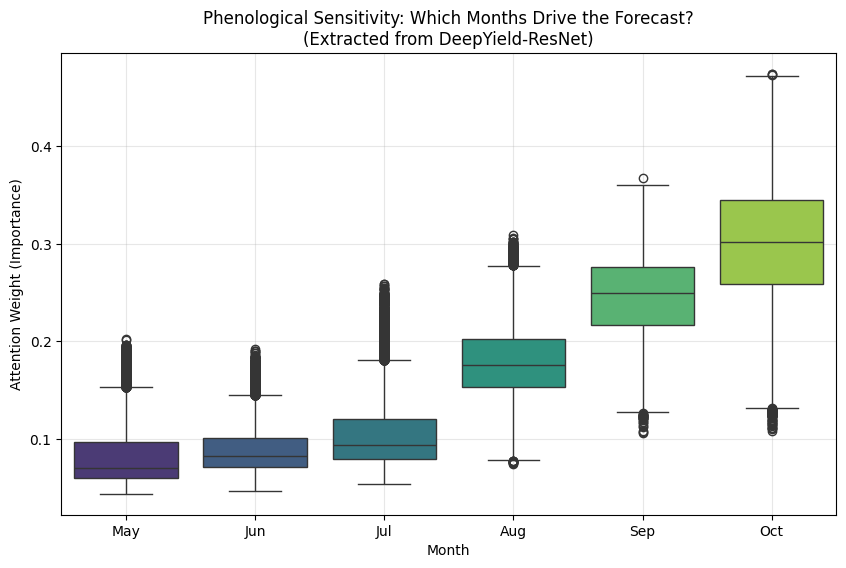

   Mean Importance per Month:
May    0.081880
Jun    0.087728
Jul    0.105185
Aug    0.178269
Sep    0.246324
Oct    0.300613
dtype: float32


In [26]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Re-Initialize the Architecture (Must match the 0.59 model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
champion_model = DeepYieldResNet(input_dim=14, hidden_dim=128, n_layers=2).to(device)

# 2. Load the Best Weights (from Experiment 4)
try:
    champion_model.load_state_dict(torch.load("best_res_attn_model.pth", map_location=device))
    print("✅ Successfully loaded 'best_res_attn_model.pth' (The 0.59 R² Model)")
except FileNotFoundError:
    print("❌ Error: Could not find 'best_res_attn_model.pth'. Did you run Experiment 4?")

# 3. Run Experiment 5: Attention Analysis
def run_experiment_5_final(model, test_loader):
    print("🧠 Starting Experiment 5: Extracting Phenological Signals...")
    model.eval()

    all_weights = []

    with torch.no_grad():
        for X, _ in test_loader:
            X = X.to(device)
            # Model returns (preds, weights)
            _, weights = model(X)
            # Squeeze: (Batch, 6, 1) -> (Batch, 6)
            all_weights.append(weights.squeeze(2).cpu().numpy())

    # Concatenate
    attention_matrix = np.concatenate(all_weights, axis=0)

    # Plotting
    months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
    df_att = pd.DataFrame(attention_matrix, columns=months)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_att, palette="viridis")
    plt.title("Phenological Sensitivity: Which Months Drive the Forecast?\n(Extracted from DeepYield-ResNet)")
    plt.ylabel("Attention Weight (Importance)")
    plt.xlabel("Month")
    plt.grid(True, alpha=0.3)
    plt.show()

    print("   Mean Importance per Month:")
    print(df_att.mean())

# Run on Test Set
run_experiment_5_final(champion_model, test_loader)

🔬 Starting Experiment 6: Driver Ablation Analysis...
   Raw Climate (Rain/Temp): +0.4939 t/ha Error
   Precipitation Memory (SPI): +0.2933 t/ha Error
   Evaporative Memory (SPEI): +0.0028 t/ha Error


/tmp/ipython-input-975/89607386.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Driver Group', y='RMSE Increase', palette='magma')


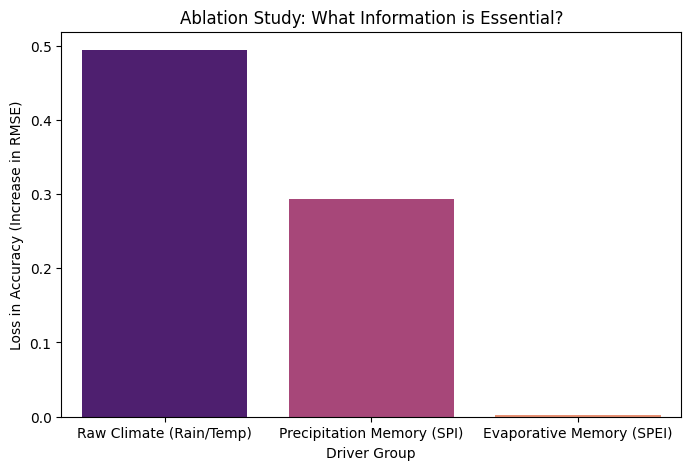

In [27]:
def run_experiment_6_final(model, test_loader):
    print("🔬 Starting Experiment 6: Driver Ablation Analysis...")
    model.eval()
    criterion = torch.nn.MSELoss()

    # 1. Get Baseline MSE
    all_X, all_y = [], []
    for X, y in test_loader:
        all_X.append(X)
        all_y.append(y)
    X_full = torch.cat(all_X).to(device)
    y_full = torch.cat(all_y).to(device)

    with torch.no_grad():
        base_pred, _ = model(X_full)
        base_mse = criterion(base_pred, y_full).item()

    # 2. Permute Groups
    groups = {
        'Raw Climate (Rain/Temp)': [0,1,2,3,4,5],
        'Precipitation Memory (SPI)': [6,7,8,9],
        'Evaporative Memory (SPEI)': [10,11,12,13]
    }

    results = []

    for group_name, indices in groups.items():
        X_perm = X_full.clone()

        # Shuffle these columns
        for idx in indices:
            perm_idx = torch.randperm(X_perm.size(0))
            X_perm[:, :, idx] = X_perm[perm_idx, :, idx]

        with torch.no_grad():
            pred_p, _ = model(X_perm)
            mse_p = criterion(pred_p, y_full).item()

        rmse_increase = np.sqrt(mse_p) - np.sqrt(base_mse)
        results.append({'Driver Group': group_name, 'RMSE Increase': rmse_increase})
        print(f"   {group_name}: +{rmse_increase:.4f} t/ha Error")

    # Plot
    import pandas as pd
    df = pd.DataFrame(results)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='Driver Group', y='RMSE Increase', palette='magma')
    plt.title("Ablation Study: What Information is Essential?")
    plt.ylabel("Loss in Accuracy (Increase in RMSE)")
    plt.show()

run_experiment_6_final(champion_model, test_loader)

[TRAIN] Loading 20 years...
[TRAIN] Loaded 152537 samples.
   Computing statistics...
🌍 Starting Experiment 7: Spatial Error Mapping for 2019...
   Using device: cpu


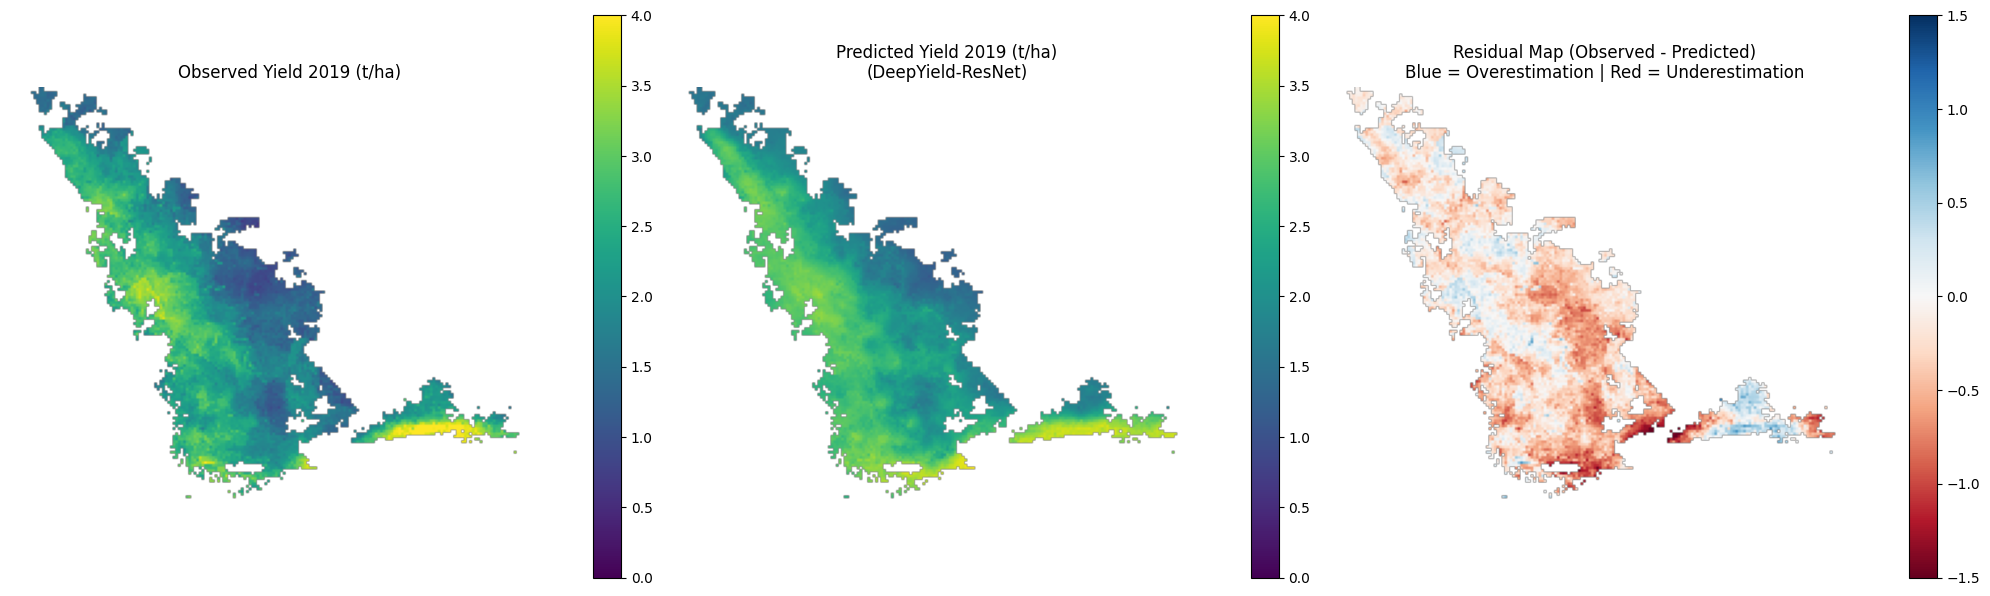

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import torch

def run_experiment_7_spatial_map(model, data_dir, year, scaler, device=None):
    print(f"🌍 Starting Experiment 7: Spatial Error Mapping for {year}...")

    # Determine device dynamically if not provided
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"   Using device: {device}")

    # 1. Load the single file manually to keep spatial structure
    fpath = os.path.join(data_dir, f"final_dataset_{year}.nc")
    try:
        ds = xr.open_dataset(fpath)
    except FileNotFoundError:
        print(f"❌ File not found: {fpath}")
        return

    # 2. Extract Features exactly like the Dataset Class
    # We need to stack them: (Time, Lat, Lon)
    feature_vars = [
        'monthly_rain', 'max_temp', 'min_temp', 'radiation',
        'vp', 'vp_deficit',
        'spi_1', 'spi_3', 'spi_6', 'spi_12',
        'spei_1', 'spei_3', 'spei_6', 'spei_12'
    ]

    # Get Yield Mask (Where yield exists)
    y_true_map = ds['yield'].values
    mask = ~np.isnan(y_true_map)

    # Prepare Input Array
    # Shape: (14, 6, H, W) -> but we need flattened pixels for the model
    # Let's extract valid pixels first
    features_list = []
    for var in feature_vars:
        data = ds[var].values # (6, H, W)
        valid_pixels = data[:, mask] # (6, N_pixels)
        features_list.append(valid_pixels)

    # Stack: (14, 6, N) -> Transpose to (N, 6, 14)
    X_spatial = np.stack(features_list, axis=0)
    X_spatial = np.transpose(X_spatial, (2, 1, 0))

    # Handle NaNs (Ocean)
    X_spatial = np.nan_to_num(X_spatial, nan=0.0)

    # 3. Normalize (Using training scaler)
    # We must replicate the scaler logic manually here
    # (X - mean) / std
    # We assume 'scaler' is the dict passed in
    mean = scaler['mean']
    std = scaler['std']

    X_spatial = (X_spatial - mean) / (std + 1e-6)

    # 4. Predict in Chunks (to avoid Memory Error)
    model.eval()
    X_tensor = torch.tensor(X_spatial, dtype=torch.float32)

    batch_size = 4096
    all_preds = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            X_batch = X_tensor[i:i+batch_size].to(device)
            # Model returns (preds, weights). We only want preds.
            preds, _ = model(X_batch)
            all_preds.append(preds.cpu().numpy())

    # Concatenate predictions
    y_pred_flat = np.concatenate(all_preds, axis=0).flatten()

    # 5. Reconstruct the Map
    pred_map = np.full(y_true_map.shape, np.nan)
    pred_map[mask] = y_pred_flat

    # Calculate Error (Observed - Predicted)
    # Positive = Model Underestimated
    # Negative = Model Overestimated
    error_map = y_true_map - pred_map

    # 6. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Observed
    im1 = axes[0].imshow(y_true_map, cmap='viridis', vmin=0, vmax=4)
    axes[0].set_title(f"Observed Yield {year} (t/ha)")
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Predicted
    im2 = axes[1].imshow(pred_map, cmap='viridis', vmin=0, vmax=4)
    axes[1].set_title(f"Predicted Yield {year} (t/ha)\n(DeepYield-ResNet)")
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Error
    # Use 'RdBu' (Red-Blue) centered at 0
    im3 = axes[2].imshow(error_map, cmap='RdBu', vmin=-1.5, vmax=1.5)
    axes[2].set_title(f"Residual Map (Observed - Predicted)\nBlue = Overestimation | Red = Underestimation")
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
# We need the 'scaler' from the training step.
# Since we didn't save it explicitly in the last run, we can quickly re-compute it
# from the train_loader dataset.
DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_modified_sequence_with_yield"

# Temporarily init a dataset just to get mean/std
temp_ds = WheatYieldDataset(DATA_DIR, range(1991, 2011), mode='train')
scaler = temp_ds.scaler

# Run for 2019 (A spatially interesting drought year)
run_experiment_7_spatial_map(champion_model, DATA_DIR, 2019, scaler)


In [29]:
import os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

def run_experiment_7_spatial_map(model, data_dir, year, scaler,
                                 shapefile_path,
                                 device=None):

    print(f"🌍 Starting Experiment 7: Spatial Error Mapping for {year}...")

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # =====================================================
    # 1️⃣ Load NetCDF
    # =====================================================
    fpath = os.path.join(data_dir, f"final_dataset_{year}.nc")
    ds = xr.open_dataset(fpath)

    lat = ds['lat'].values
    lon = ds['lon'].values

    # Detect latitude orientation automatically
    if lat[0] > lat[-1]:
        origin_setting = 'upper'
    else:
        origin_setting = 'lower'

    extent = [lon.min(), lon.max(), lat.min(), lat.max()]

    # =====================================================
    # 2️⃣ Load Shapefile
    # =====================================================
    qld_shape = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

    # =====================================================
    # 3️⃣ Prepare Data
    # =====================================================
    feature_vars = [
        'monthly_rain', 'max_temp', 'min_temp', 'radiation',
        'vp', 'vp_deficit',
        'spi_1', 'spi_3', 'spi_6', 'spi_12',
        'spei_1', 'spei_3', 'spei_6', 'spei_12'
    ]

    y_true_map = ds['yield'].values
    mask = ~np.isnan(y_true_map)

    features_list = []
    for var in feature_vars:
        data = ds[var].values  # (6, H, W)
        valid_pixels = data[:, mask]
        features_list.append(valid_pixels)

    # Stack to (N, 6, 14)
    X_spatial = np.stack(features_list, axis=0)
    X_spatial = np.transpose(X_spatial, (2, 1, 0))
    X_spatial = np.nan_to_num(X_spatial, nan=0.0)

    # Normalize
    mean = scaler['mean']
    std = scaler['std']
    X_spatial = (X_spatial - mean) / (std + 1e-6)

    # =====================================================
    # 4️⃣ Predict in Batches
    # =====================================================
    model.eval()
    X_tensor = torch.tensor(X_spatial, dtype=torch.float32)

    batch_size = 4096
    all_preds = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            X_batch = X_tensor[i:i+batch_size].to(device)
            preds, _ = model(X_batch)
            all_preds.append(preds.cpu().numpy())

    y_pred_flat = np.concatenate(all_preds).flatten()

    # =====================================================
    # 5️⃣ Reconstruct Maps
    # =====================================================
    pred_map = np.full(y_true_map.shape, np.nan)
    pred_map[mask] = y_pred_flat

    error_map = y_true_map - pred_map

    # =====================================================
    # 6️⃣ Plot
    # =====================================================
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # --- Observed ---
    im1 = axes[0].imshow(
        y_true_map,
        cmap='viridis',
        vmin=0, vmax=4,
        extent=extent,
        origin=origin_setting
    )
    qld_shape.boundary.plot(ax=axes[0], color='black', linewidth=1)
    axes[0].set_title(f"Observed Yield {year} (t/ha)")
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Predicted ---
    im2 = axes[1].imshow(
        pred_map,
        cmap='viridis',
        vmin=0, vmax=4,
        extent=extent,
        origin=origin_setting
    )
    qld_shape.boundary.plot(ax=axes[1], color='black', linewidth=1)
    axes[1].set_title(f"Predicted Yield {year} (t/ha)")
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # --- Residual Map ---
    norm = TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)

    im3 = axes[2].imshow(
        error_map,
        cmap='RdBu',
        norm=norm,
        extent=extent,
        origin=origin_setting
    )
    qld_shape.boundary.plot(ax=axes[2], color='#9E9E9E', linewidth=0.8)
    axes[2].set_title("Residual (Observed - Predicted)")
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Axis labels
    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

🌍 Starting Experiment 7: Spatial Error Mapping for 2019...
Using device: cpu


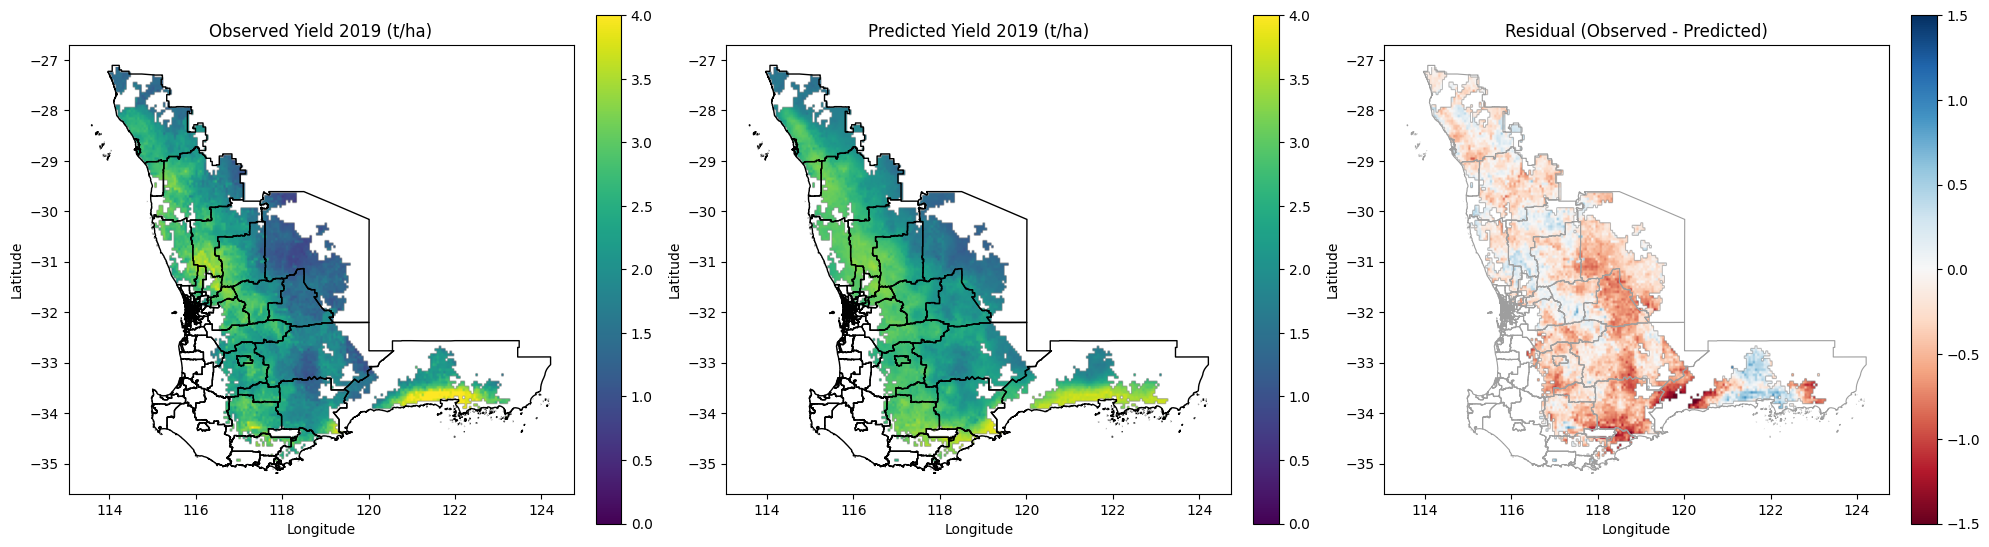

In [30]:
shapefile_path = r'/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Eastern_Aus_Bunbury/Eastern_Aus_Bunbury.shp'

run_experiment_7_spatial_map(
    champion_model,
    DATA_DIR,
    2019,
    scaler,
    shapefile_path
)